In [9]:
import cv2 as cv
import numpy as np

In [10]:
from evaluation.config import *

time_config = TimingConfig(
    frames_per_sec=60,
    imaging_time_ms=200,
    pred_time_ms=40,
    moving_time_ms=50,
    px_per_mm=90,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.225, 0.225),
)

Correlation Coefficient: 0.67
Correlation Slope: 0.50


,wrm_speed,bbox_area_diff
count,4078.000000,4078.000000
mean,0.292169,0.050093
std,0.147318,0.108790
min,0.072320,0.000000
10%,0.142816,0.000000
20%,0.170476,0.000000
30%,0.199372,0.000000
40%,0.231870,0.000000
50%,0.263175,0.000000
60%,0.298188,0.003542


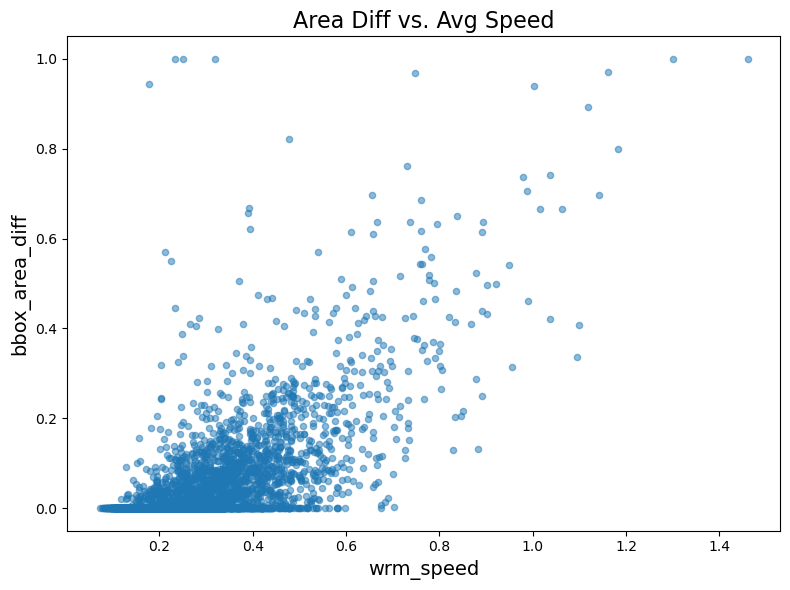

In [11]:
from evaluation.analysis import Plotter
plt = Plotter("logs2/bboxes.csv", time_config)
plt.plot_area_vs_speed()

In [ ]:
cv.destroyAllWindows()
raise Exception("Finished")

In [1]:
from evaluation.simulator import *
from evaluation.sim_controllers import *
from utils.path_utils import Files
from evaluation.config import *

experiment_config = ExperimentConfig(
    name="exp1",
    num_frames=61200,
    frames_per_sec=60,
    orig_resolution=(1920, 1080),
    px_per_mm=90,
    init_position=(1300, 1200),
)

""" experiment_config = ExperimentConfig(
    name="exp1",
    num_frames=1200,
    frames_per_sec=60,
    orig_resolution=(1920, 1080),
    px_per_mm=90,
    init_position=(1300, 1200),
) """

time_config = TimingConfig(
    frames_per_sec=60,
    imaging_time_ms=200,
    pred_time_ms=40,
    moving_time_ms=50,
    px_per_mm=90,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.225, 0.225),
)

log_config = LogConfig(
    root_folder="logs2/",
    save_mic_view=False,
    save_cam_view=False,
    save_err_view=False,
)

yolo_config = YoloConfig(
    model_path="yolov8m-trained.pt",
    verbose=True,
)

log_config.create_dirs()


""" time_config.save_json("logs/time_config.json")
log_config.save_json("logs/log_config.json")
yolo_config.save_json("logs/yolo_config.json") 
experiment_config.save_json("logs/experiment_config.json") """

"""
frames_path = "Archive/"
files = Files(frames_path, extension="Bmp", sorting_key=lambda f: int(f.split("-")[-1].split(".")[0]))
files_list = [file for file in files]
reader = FrameReader(frames_path, files_list) """

# reader = FrameReader.create_from_directory("/mnt/c/Users/freid/Desktop/eval/micro")


""" time_config = TimingConfig.load_json("logs/time_config.json")
log_config = LogConfig.load_json("logs/log_config.json")
yolo_config = YoloConfig.load_json("logs/yolo_config.json") """

' time_config = TimingConfig.load_json("logs/time_config.json")\nlog_config = LogConfig.load_json("logs/log_config.json")\nyolo_config = YoloConfig.load_json("logs/yolo_config.json") '

In [ ]:
print(time_config.imaging_frame_num + time_config.moving_frame_num)

In [7]:
from evaluation.sim_controllers.test_controller1 import TestController1
from evaluation.sim_controllers.polyfit_controller import PolyfitController

# sim_controller = YoloController(time_config, yolo_config)
sim_controller = TestController1(time_config, "bboxes.csv")

#sim_controller = PolyfitController(time_config, "bboxes.csv", degree=1)
#sim_controller = OptimalController(time_config, "bboxes.csv")
#sim_controller = CsvController(time_config, "bboxes.csv")
log_controller = LoggingController(sim_controller, log_config)
sim = Simulator(time_config, experiment_config, log_controller)

In [8]:
sim.run(visualize=False)

Simulation Progress:   0%|          | 0/4080 [00:00<?, ?cycle/s]

In [ ]:
from cProfile import Profile
from pstats import Stats, SortKey

with Profile() as pr:
    sim.run(visualize=False)
    Stats(pr).sort_stats(SortKey.CUMULATIVE).print_stats()

In [ ]:
cv.destroyAllWindows()
raise Exception("Finished")

In [ ]:
from frame_reader import FrameReader

reader = FrameReader.create_from_directory("Archive/")

In [ ]:
from dataset.create.box_calculator import BoxCalculator
from dataset.create.sample_extractor import SampleExtractor

bbox_calc = BoxCalculator(reader)
extractor = SampleExtractor(bbox_calc)
extractor.create_all_samples(target_size=(400, 400), save_folder="samples")

In [ ]:
import pandas as pd
import numpy as np

from evaluation.simulator import *
from dataset.bbox_utils import *


np.set_printoptions(precision=2)

class PolyEvaluator:
    def __init__(
        self,
        csv_path: str,
        timing_config: TimingConfig,
        input_offsets: np.ndarray,
        start_times: np.ndarray,
        eval_offset: int,
    ):
        self.timing_config = timing_config
        self.eval_offset = eval_offset

        bboxes = pd.read_csv(csv_path, usecols=["wrm_x", "wrm_y", "wrm_w", "wrm_h"]).to_numpy(dtype=float)

        self.positions = np.empty((len(bboxes), 2), dtype=float)
        self.positions[:, 0] = bboxes[:, 0] + bboxes[:, 2] / 2
        self.positions[:, 1] = bboxes[:, 1] + bboxes[:, 3] / 2

        self.input_offsets = np.sort(input_offsets)
        self.start_times = start_times

        self._initialize()

    def _initialize(self):
        N = self.input_offsets.shape[0]

        # create data arrays
        input_times = np.repeat(self.start_times, repeats=N) + np.tile(self.input_offsets, reps=self.start_times.shape[0]) 
        input_pos = self.positions[input_times, :]  
        dst_times = self.start_times + self.eval_offset
        dst_pos = self.positions[dst_times, :]

        # remove invalid positions according to dst
        dst_mask = np.all(np.isfinite(dst_pos), axis=-1)
        mask = np.repeat(dst_mask, repeats=N, axis=0)
        input_pos = input_pos[mask, :]
        dst_pos = dst_pos[dst_mask, :]

        # remove invalid positions according to input
        input_mask = np.isfinite(input_pos).reshape(-1, N, 2)
        input_mask = np.all(np.all(input_mask, axis=-1), axis=-1)

        input_pos = input_pos.reshape(-1, N, 2)
        input_pos = input_pos[input_mask, :, :]
        dst_pos = dst_pos[input_mask, :]

        self.x_input = self.input_offsets.reshape(N)
        self.y_input = input_pos.swapaxes(0, 1).reshape(N, -1)
        self.x_target = np.asanyarray([self.eval_offset])
        self.y_target = dst_pos.reshape(-1)

    def polyval(self, coeffs: np.ndarray, x: np.ndarray) -> np.ndarray:
        """
        Evaluate a polynomial at given values.

        Args:
            coeffs (np.ndarray): Coefficients of the polynomial. Coefficients at decreasing order. Should have shape [deg+1, N].
            x (np.ndarray): Values at which to evaluate the polynomial. Should have shape [N].

        Returns:
            np.ndarray: The result of evaluating the polynomial at the given values. Shape is [N].

        """
        coeffs = coeffs.swapaxes(0, 1)
        van = np.vander(x, N=coeffs.shape[1], increasing=False)
        return np.sum(van * coeffs, axis=-1)

    def eval(self, weights: np.ndarray, deg: int = 2) -> float:
        """
        Evaluate the mean absolute error (MAE) of the polynomial fit.

        Args:
            weights (np.ndarray): The weights used for the polynomial fit. Should have shape [N].
            deg (int, optional): The degree of the polynomial fit. Defaults to 2.

        Returns:
            float: The mean squared error (MSE) of the polynomial fit.
        """
        coeffs = np.polyfit(self.x_input, self.y_input, deg=deg, w=weights)
        x_target = np.broadcast_to(self.x_target, shape=(coeffs.shape[1],))
        y_hat = self.polyval(coeffs, x_target)
        mae = np.mean(np.abs(self.y_target - y_hat))
        return mae

In [ ]:
# input_offsets = np.asanyarray([0, 3, 6, 9])

input_offsets = np.asanyarray(
    [
        0,
        5,
        9,
        time_config.cycle_length + 0,
        time_config.cycle_length + 5,
        time_config.cycle_length + 9,
        2 * time_config.cycle_length + 0,
        2 * time_config.cycle_length + 5,
        2 * time_config.cycle_length + 9,
    ]
)

start_times = np.arange(60000 // time_config.cycle_length) * time_config.cycle_length
# start_times = np.concatenate((start_times, np.array([21997 - 18])))

evaluator = PolyEvaluator(
    "bboxes.csv",
    time_config,
    input_offsets=input_offsets,
    start_times=start_times,
    eval_offset=3 * time_config.cycle_length + time_config.imaging_frame_num // 2,
)

In [ ]:
def eval_func(weights: np.ndarray) -> float:
    return evaluator.eval(weights, deg=3)

In [ ]:
from mealpy.swarm_based.PSO import OriginalPSO
from mealpy.utils.problem import Problem
from mealpy.utils.termination import Termination
from mealpy.utils.agent import Agent
import mealpy

#optim = mealpy.ICA.OriginalICA()
optim = mealpy.PSO.OriginalPSO()

termination = Termination(max_epoch=300, max_fe=None, max_time=None, max_early_stop=100)

bounds = mealpy.FloatVar(lb=np.zeros(len(input_offsets)), ub=np.ones(len(input_offsets)))

problem = Problem(obj_func=eval_func, bounds=bounds, minimax="min")

best: Agent = optim.solve(
    problem,
    mode="swarm",
    n_workers=5,
    termination=termination,
)

In [ ]:
np.set_printoptions(precision=4, suppress=True)

print(optim.g_best.target.fitness)
print(optim.g_best.solution / np.linalg.norm(best.solution))

In [ ]:
#2: 1.48
#1: 1.48

In [ ]:
import numpy as np

arr = np.asanyarray(
    [
        [
            [np.nan, np.nan],
            [1, 1],
        ],
        [
            [2, 2],
            [1, 1],
        ],
    ]
)

print(arr.shape)

print(np.all(np.isfinite(arr), axis=1))